## Yolov4 Workflow
- 解析資料並生成訓練/驗證/測試集
- training data 使用07train+12train,
- val data 使用07val+12val
- testing data使用07test

### 解析資料並生成訓練/驗證/測試集

In [4]:
# 要先有Imagesets裡面的train, val, test, ...txt才能生成2007_train.txt, ...
import os
import random
import xml.etree.ElementTree as ET

from utils.utils import get_classes

#--------------------------------------------------------------------------------------------------------------------------------#
#   annotation_mode用于指定该文件运行时计算的内容, 
#   annotation_mode为0代表整个标签处理过程，包括获得VOCdevkit/VOC2007/ImageSets里面的txt以及训练用的2007_train.txt、2007_val.txt
#   annotation_mode为1代表获得VOCdevkit/VOC2007/ImageSets里面的txt
#   annotation_mode为2代表获得训练用的2007_train.txt、2007_val.txt
#--------------------------------------------------------------------------------------------------------------------------------#
annotation_mode     = 2
#-------------------------------------------------------------------#
#   必须要修改，用于生成2007_train.txt、2007_val.txt的目标信息
#   与训练和预测所用的classes_path一致即可
#   如果生成的2007_train.txt里面没有目标信息
#   那么就是因为classes没有设定正确
#   仅在annotation_mode为0和2的时候有效
#-------------------------------------------------------------------#
classes_path        = 'model_data/voc_classes.txt'
#--------------------------------------------------------------------------------------------------------------------------------#
#   trainval_percent用于指定(训练集+验证集)与测试集的比例，默认情况下 (训练集+验证集):测试集 = 9:1
#   train_percent用于指定(训练集+验证集)中训练集与验证集的比例，默认情况下 训练集:验证集 = 9:1
#   仅在annotation_mode为0和1的时候有效
#--------------------------------------------------------------------------------------------------------------------------------#
trainval_percent    = 0.9
train_percent       = 0.9
#-------------------------------------------------------#
#   指向VOC数据集所在的文件夹
#   默认指向根目录下的VOC数据集
#-------------------------------------------------------#
VOCdevkit_path  = 'D:/Python/Data/VOC0712/VOCdevkit'

# 要符合ImageSets/Main中想要訓練的train.txt / val.txt名稱
VOCdevkit_sets  = [('2007', 'train0712'), ('2007', 'val0712')] # VOC2007資料夾中的train.txt和test.txt
classes, _      = get_classes(classes_path)

def convert_annotation(year, image_id, list_file):
    in_file = open(os.path.join(VOCdevkit_path, 'VOC%s/Annotations/%s.xml'%(year, image_id)), encoding='utf-8')
    tree=ET.parse(in_file)
    root = tree.getroot()

    for obj in root.iter('object'):
        difficult = 0 
        if obj.find('difficult')!=None:
            difficult = obj.find('difficult').text
        cls = obj.find('name').text
        if cls not in classes or int(difficult)==1:
            continue
        cls_id = classes.index(cls)
        xmlbox = obj.find('bndbox')
        b = (int(float(xmlbox.find('xmin').text)), int(float(xmlbox.find('ymin').text)), int(float(xmlbox.find('xmax').text)), int(float(xmlbox.find('ymax').text)))
        list_file.write(" " + ",".join([str(a) for a in b]) + ',' + str(cls_id))

In [5]:
random.seed(0)
if annotation_mode == 0 or annotation_mode == 1:
    print("Generate txt in ImageSets.")
    xmlfilepath     = os.path.join(VOCdevkit_path, 'VOC2007/Annotations')
    saveBasePath    = os.path.join(VOCdevkit_path, 'VOC2007/ImageSets/Main')
    temp_xml        = os.listdir(xmlfilepath)
    total_xml       = []
    for xml in temp_xml:
        if xml.endswith(".xml"):
            total_xml.append(xml)

    num     = len(total_xml)  
    list    = range(num)  
    tv      = int(num*trainval_percent)  
    tr      = int(tv*train_percent)  
    trainval= random.sample(list,tv)  
    train   = random.sample(trainval,tr)  

    print("train and val size",tv)
    print("train size",tr)
    ftrainval   = open(os.path.join(saveBasePath,'trainval.txt'), 'w')  
    ftest       = open(os.path.join(saveBasePath,'test.txt'), 'w')  
    ftrain      = open(os.path.join(saveBasePath,'train.txt'), 'w')  
    fval        = open(os.path.join(saveBasePath,'val.txt'), 'w')  

    for i in list:  
        name=total_xml[i][:-4]+'\n'  
        if i in trainval:  
            ftrainval.write(name)  
            if i in train:  
                ftrain.write(name)  
            else:  
                fval.write(name)  
        else:  
            ftest.write(name)  

    ftrainval.close()  
    ftrain.close()  
    fval.close()  
    ftest.close()
    print("Generate txt in ImageSets done.")

if annotation_mode == 0 or annotation_mode == 2:
    print("Generate 2007_train.txt and 2007_val.txt for train.")
    for year, image_set in VOCdevkit_sets:
        image_ids = open(os.path.join(VOCdevkit_path, 'VOC%s/ImageSets/Main/%s.txt'%(year, image_set)), encoding='utf-8').read().strip().split()
        list_file = open('%s_%s.txt'%(year, image_set), 'w', encoding='utf-8')
        for image_id in image_ids:
            list_file.write('%s/VOC%s/JPEGImages/%s.jpg'%(os.path.abspath(VOCdevkit_path), year, image_id))

            convert_annotation(year, image_id, list_file)
            list_file.write('\n')
        list_file.close()
    print("Generate 2007_train.txt and 2007_val.txt for train done.")

Generate 2007_train.txt and 2007_val.txt for train.
Generate 2007_train.txt and 2007_val.txt for train done.


### 訓練模型 

In [32]:
import datetime
import os
from functools import partial

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import (EarlyStopping, LearningRateScheduler,
                                        TensorBoard)
from tensorflow.keras.optimizers import SGD, Adam

from nets.yolo import get_train_model, yolo_body
from nets.yolo_training import get_lr_scheduler
from utils.callbacks import LossHistory, ModelCheckpoint
from utils.dataloader import YoloDatasets
from utils.utils import get_anchors, get_classes
from utils.utils_fit import fit_one_epoch

gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
  
# '''
# 训练自己的目标检测模型一定需要注意以下几点：
# 1、训练前仔细检查自己的格式是否满足要求，该库要求数据集格式为VOC格式，需要准备好的内容有输入图片和标签
#    输入图片为.jpg图片，无需固定大小，传入训练前会自动进行resize。
#    灰度图会自动转成RGB图片进行训练，无需自己修改。
#    输入图片如果后缀非jpg，需要自己批量转成jpg后再开始训练。
#    标签为.xml格式，文件中会有需要检测的目标信息，标签文件和输入图片文件相对应。
# 2、训练好的权值文件保存在logs文件夹中，每个epoch都会保存一次，如果只是训练了几个step是不会保存的，epoch和step的概念要捋清楚一下。
#    在训练过程中，该代码并没有设定只保存最低损失的，因此按默认参数训练完会有100个权值，如果空间不够可以自行删除。
#    这个并不是保存越少越好也不是保存越多越好，有人想要都保存、有人想只保存一点，为了满足大多数的需求，还是都保存可选择性高。
# 3、损失值的大小用于判断是否收敛，比较重要的是有收敛的趋势，即验证集损失不断下降，如果验证集损失基本上不改变的话，模型基本上就收敛了。
#    损失值的具体大小并没有什么意义，大和小只在于损失的计算方式，并不是接近于0才好。如果想要让损失好看点，可以直接到对应的损失函数里面除上10000。
#    训练过程中的损失值会保存在logs文件夹下的loss_%Y_%m_%d_%H_%M_%S文件夹中
# 4、调参是一门蛮重要的学问，没有什么参数是一定好的，现有的参数是我测试过可以正常训练的参数，因此我会建议用现有的参数。
#    但是参数本身并不是绝对的，比如随着batch的增大学习率也可以增大，效果也会好一些；过深的网络不要用太大的学习率等等。
#    这些都是经验上，只能靠各位同学多查询资料和自己试试了。
# '''

In [35]:
 #----------------------------------------------------#
#   是否使用eager模式训练
#----------------------------------------------------#
eager           = False
#---------------------------------------------------------------------#
#   classes_path    指向model_data下的txt，与自己训练的数据集相关 
#                   训练前一定要修改classes_path，使其对应自己的数据集
#---------------------------------------------------------------------#
classes_path    = 'model_data/voc_classes.txt'
#---------------------------------------------------------------------#
#   anchors_path    代表先验框对应的txt文件，一般不修改。
#   anchors_mask    用于帮助代码找到对应的先验框，一般不修改。
#---------------------------------------------------------------------#
anchors_path    = 'model_data/yolo_anchors.txt'
anchors_mask    = [[6, 7, 8], [3, 4, 5], [0, 1, 2]]
#----------------------------------------------------------------------------------------------------------------------------#
#   权值文件的下载请看README，可以通过网盘下载。模型的 预训练权重 对不同数据集是通用的，因为特征是通用的。
#   模型的 预训练权重 比较重要的部分是 主干特征提取网络的权值部分，用于进行特征提取。
#   预训练权重对于99%的情况都必须要用，不用的话主干部分的权值太过随机，特征提取效果不明显，网络训练的结果也不会好
#
#   如果训练过程中存在中断训练的操作，可以将model_path设置成logs文件夹下的权值文件，将已经训练了一部分的权值再次载入。
#   同时修改下方的 冻结阶段 或者 解冻阶段 的参数，来保证模型epoch的连续性。
#   
#   当model_path = ''的时候不加载整个模型的权值。
#
#   此处使用的是整个模型的权重，因此是在train.py进行加载的。
#   如果想要让模型从主干的预训练权值开始训练，则设置model_path为主干网络的权值，此时仅加载主干。
#   如果想要让模型从0开始训练，则设置model_path = ''，Freeze_Train = Fasle，此时从0开始训练，且没有冻结主干的过程。
#   
#   一般来讲，网络从0开始的训练效果会很差，因为权值太过随机，特征提取效果不明显，因此非常、非常、非常不建议大家从0开始训练！
#   从0开始训练有两个方案：
#   1、得益于Mosaic数据增强方法强大的数据增强能力，将UnFreeze_Epoch设置的较大（300及以上）、batch较大（16及以上）、数据较多（万以上）的情况下，
#      可以设置mosaic=True，直接随机初始化参数开始训练，但得到的效果仍然不如有预训练的情况。（像COCO这样的大数据集可以这样做）
#   2、了解imagenet数据集，首先训练分类模型，获得网络的主干部分权值，分类模型的 主干部分 和该模型通用，基于此进行训练。
#----------------------------------------------------------------------------------------------------------------------------#
model_path      = 'model_data/yolo4_coco_weight.h5' # COCO預訓練的權重
#------------------------------------------------------#
#   input_shape     输入的shape大小，一定要是32的倍数
#------------------------------------------------------#
input_shape     = [416, 416] # 可改為608*608
#------------------------------------------------------------------#
#   mosaic          马赛克数据增强
#                   参考YoloX，由于Mosaic生成的训练图片，
#                   远远脱离自然图片的真实分布。
#                   本代码会在训练结束前的N个epoch自动关掉Mosaic
#                   100个世代会关闭30个世代（比例可在dataloader.py调整）
#   label_smoothing 标签平滑。一般0.01以下。如0.01、0.005
#
#   余弦退火算法的参数放到下面的lr_decay_type中设置
#------------------------------------------------------------------#
mosaic              = True
label_smoothing     = 0

#----------------------------------------------------------------------------------------------------------------------------#
#   训练分为两个阶段，分别是冻结阶段和解冻阶段。设置冻结阶段是为了满足机器性能不足的同学的训练需求。
#   冻结训练需要的显存较小，显卡非常差的情况下，可设置Freeze_Epoch等于UnFreeze_Epoch，此时仅仅进行冻结训练。
#      
#   在此提供若干参数设置建议，各位训练者根据自己的需求进行灵活调整：
#   （一）从整个模型的预训练权重开始训练： 
#       Init_Epoch = 0，Freeze_Epoch = 50，UnFreeze_Epoch = 100，Freeze_Train = True（默认参数）
#       Init_Epoch = 0，UnFreeze_Epoch = 100，Freeze_Train = False（不冻结训练）
#       其中：UnFreeze_Epoch可以在100-300之间调整。optimizer_type = 'sgd'，Init_lr = 1e-2。
#   （二）从主干网络的预训练权重开始训练：
#       Init_Epoch = 0，Freeze_Epoch = 50，UnFreeze_Epoch = 300，Freeze_Train = True（冻结训练）
#       Init_Epoch = 0，UnFreeze_Epoch = 300，Freeze_Train = False（不冻结训练）
#       其中：由于从主干网络的预训练权重开始训练，主干的权值不一定适合目标检测，需要更多的训练跳出局部最优解。
#             UnFreeze_Epoch可以在200-300之间调整，YOLOV5和YOLOX均推荐使用300。optimizer_type = 'sgd'，Init_lr = 1e-2。
#   （三）从0开始训练：
#       Init_Epoch = 0，UnFreeze_Epoch >= 300，Unfreeze_batch_size >= 16，Freeze_Train = False（不冻结训练）
#       其中：UnFreeze_Epoch尽量不小于300。optimizer_type = 'sgd'，Init_lr = 1e-2，mosaic = True。
#   （四）batch_size的设置：
#       在显卡能够接受的范围内，以大为好。显存不足与数据集大小无关，提示显存不足（OOM或者CUDA out of memory）请调小batch_size。
#       受到BatchNorm层影响，batch_size最小为2，不能为1。
#       正常情况下Freeze_batch_size建议为Unfreeze_batch_size的1-2倍。不建议设置的差距过大，因为关系到学习率的自动调整。
#----------------------------------------------------------------------------------------------------------------------------#
#------------------------------------------------------------------#
#   冻结阶段训练参数
#   此时模型的主干被冻结了，特征提取网络不发生改变
#   占用的显存较小，仅对网络进行微调
#   Init_Epoch          模型当前开始的训练世代，其值可以大于Freeze_Epoch，如设置：
#                       Init_Epoch = 60、Freeze_Epoch = 50、UnFreeze_Epoch = 100
#                       会跳过冻结阶段，直接从60代开始，并调整对应的学习率。
#                       （断点续练时使用）
#   Freeze_Epoch        模型冻结训练的Freeze_Epoch
#                       (当Freeze_Train=False时失效)
#   Freeze_batch_size   模型冻结训练的batch_size
#                       (当Freeze_Train=False时失效)
#------------------------------------------------------------------#
Init_Epoch          = 0
Freeze_Epoch        = 50
Freeze_batch_size   = 8
#------------------------------------------------------------------#
#   解冻阶段训练参数
#   此时模型的主干不被冻结了，特征提取网络会发生改变
#   占用的显存较大，网络所有的参数都会发生改变
#   UnFreeze_Epoch          模型总共训练的epoch
#   Unfreeze_batch_size     模型在解冻后的batch_size
#------------------------------------------------------------------#
UnFreeze_Epoch      = 100
Unfreeze_batch_size = 4
#------------------------------------------------------------------#
#   Freeze_Train    是否进行冻结训练
#                   默认先冻结主干训练后解冻训练。
#                   如果设置Freeze_Train=False，建议使用优化器为sgd
#------------------------------------------------------------------#
Freeze_Train        = True

#------------------------------------------------------------------#
#   其它训练参数：学习率、优化器、学习率下降有关
#------------------------------------------------------------------#
#------------------------------------------------------------------#
#   Init_lr         模型的最大学习率
#                   当使用Adam优化器时建议设置  Init_lr=1e-3
#                   当使用SGD优化器时建议设置   Init_lr=1e-2
#   Min_lr          模型的最小学习率，默认为最大学习率的0.01
#------------------------------------------------------------------#
Init_lr             = 1e-2
Min_lr              = Init_lr * 0.01
#------------------------------------------------------------------#
#   optimizer_type  使用到的优化器种类，可选的有adam、sgd
#                   当使用Adam优化器时建议设置  Init_lr=1e-3
#                   当使用SGD优化器时建议设置   Init_lr=1e-2
#   momentum        优化器内部使用到的momentum参数
#   weight_decay    权值衰减，可防止过拟合
#                   adam会导致weight_decay错误，使用adam时建议设置为0。
#------------------------------------------------------------------#
optimizer_type      = "sgd"
momentum            = 0.937
weight_decay        = 5e-4
#------------------------------------------------------------------#
#   lr_decay_type   使用到的学习率下降方式，可选的有'step'、'cos'
#------------------------------------------------------------------#
lr_decay_type       = 'cos'
#------------------------------------------------------------------#
#   save_period     多少个epoch保存一次权值，默认每个世代都保存
#------------------------------------------------------------------#
save_period         = 1
#------------------------------------------------------------------#
#   save_dir        权值与日志文件保存的文件夹
#------------------------------------------------------------------#
save_dir            = 'logs'
#------------------------------------------------------------------#
#   num_workers     用于设置是否使用多线程读取数据，1代表关闭多线程
#                   开启后会加快数据读取速度，但是会占用更多内存
#                   keras里开启多线程有些时候速度反而慢了许多
#                   在IO为瓶颈的时候再开启多线程，即GPU运算速度远大于读取图片的速度。
#------------------------------------------------------------------#
num_workers         = 1

#------------------------------------------------------#
#   train_annotation_path   训练图片路径和标签
#   val_annotation_path     验证图片路径和标签
#   txt檔案的名稱要符合voc_annotation.py生成的名稱(可設定)
#------------------------------------------------------#
# train_annotation_path   = '2007_train.txt'
# val_annotation_path     = '2007_val.txt'
train_annotation_path   = '2007_train0712.txt'
val_annotation_path     = '2007_val0712.txt'

#----------------------------------------------------#
#   获取classes和anchor
#----------------------------------------------------#
class_names, num_classes = get_classes(classes_path)
anchors, num_anchors     = get_anchors(anchors_path)

#------------------------------------------------------#
#   创建yolo模型
#------------------------------------------------------#
model_body  = yolo_body((None, None, 3), anchors_mask, num_classes, weight_decay)
if model_path != '':
    #------------------------------------------------------#
    #   载入预训练权重
    #------------------------------------------------------#
    print('Load weights {}.'.format(model_path))
    model_body.load_weights(model_path, by_name=True, skip_mismatch=True)

if not eager:
    model = get_train_model(model_body, input_shape, num_classes, anchors, anchors_mask, label_smoothing)

#---------------------------#
#   读取数据集对应的txt
#---------------------------#
with open(train_annotation_path, encoding='utf-8') as f:
    train_lines = f.readlines()
with open(val_annotation_path, encoding='utf-8') as f:
    val_lines   = f.readlines()
num_train   = len(train_lines)
num_val     = len(val_lines)

#------------------------------------------------------#
#   主干特征提取网络特征通用，冻结训练可以加快训练速度
#   也可以在训练初期防止权值被破坏。
#   Init_Epoch为起始世代
#   Freeze_Epoch为冻结训练的世代
#   UnFreeze_Epoch总训练世代
#   提示OOM或者显存不足请调小Batch_size
#------------------------------------------------------#
if True:
    if Freeze_Train:
        freeze_layers = 249
        for i in range(freeze_layers): model_body.layers[i].trainable = False
        print('Freeze the first {} layers of total {} layers.'.format(freeze_layers, len(model_body.layers)))

    #-------------------------------------------------------------------#
    #   如果不冻结训练的话，直接设置batch_size为Unfreeze_batch_size
    #-------------------------------------------------------------------#
    batch_size  = Freeze_batch_size if Freeze_Train else Unfreeze_batch_size

    #-------------------------------------------------------------------#
    #   判断当前batch_size与64的差别，自适应调整学习率
    #-------------------------------------------------------------------#
    nbs     = 64
    Init_lr_fit = max(batch_size / nbs * Init_lr, 3e-4)
    Min_lr_fit  = max(batch_size / nbs * Min_lr, 3e-6)

    #---------------------------------------#
    #   获得学习率下降的公式
    #---------------------------------------#
    lr_scheduler_func = get_lr_scheduler(lr_decay_type, Init_lr_fit, Min_lr_fit, UnFreeze_Epoch)

    epoch_step      = num_train // batch_size
    epoch_step_val  = num_val // batch_size

    if epoch_step == 0 or epoch_step_val == 0:
        raise ValueError('数据集过小，无法进行训练，请扩充数据集。')

    train_dataloader    = YoloDatasets(train_lines, input_shape, anchors, batch_size, num_classes, anchors_mask, Init_Epoch, UnFreeze_Epoch, mosaic = mosaic, train = True)
    val_dataloader      = YoloDatasets(val_lines, input_shape, anchors, batch_size, num_classes, anchors_mask, Init_Epoch, UnFreeze_Epoch, mosaic = False, train = False)

    optimizer = {
        'adam'  : Adam(lr = Init_lr, beta_1 = momentum),
        'sgd'   : SGD(lr = Init_lr, momentum = momentum, nesterov=True)
    }[optimizer_type]

    if eager:
        start_epoch     = Init_Epoch
        end_epoch       = UnFreeze_Epoch
        UnFreeze_flag   = False

        gen     = tf.data.Dataset.from_generator(partial(train_dataloader.generate), (tf.float32, tf.float32, tf.float32, tf.float32))
        gen_val = tf.data.Dataset.from_generator(partial(val_dataloader.generate), (tf.float32, tf.float32, tf.float32, tf.float32))

        gen     = gen.shuffle(buffer_size = batch_size).prefetch(buffer_size = batch_size)
        gen_val = gen_val.shuffle(buffer_size = batch_size).prefetch(buffer_size = batch_size)

        time_str        = datetime.datetime.strftime(datetime.datetime.now(),'%Y_%m_%d_%H_%M_%S')
        log_dir         = os.path.join(save_dir, "loss_" + str(time_str))
        loss_history    = LossHistory(log_dir)
        #---------------------------------------#
        #   开始模型训练
        #---------------------------------------#
        for epoch in range(start_epoch, end_epoch):
            #---------------------------------------#
            #   如果模型有冻结学习部分
            #   则解冻，并设置参数
            #---------------------------------------#
            if epoch >= Freeze_Epoch and not UnFreeze_flag and Freeze_Train:
                batch_size      = Unfreeze_batch_size

                #-------------------------------------------------------------------#
                #   判断当前batch_size与64的差别，自适应调整学习率
                #-------------------------------------------------------------------#
                nbs     = 64
                Init_lr_fit = max(batch_size / nbs * Init_lr, 3e-4)
                Min_lr_fit  = max(batch_size / nbs * Min_lr, 3e-6)
                #---------------------------------------#
                #   获得学习率下降的公式
                #---------------------------------------#
                lr_scheduler_func = get_lr_scheduler(lr_decay_type, Init_lr_fit, Min_lr_fit, UnFreeze_Epoch)

                for i in range(len(model_body.layers)): 
                    model_body.layers[i].trainable = True

                epoch_step      = num_train // batch_size
                epoch_step_val  = num_val // batch_size

                if epoch_step == 0 or epoch_step_val == 0:
                    raise ValueError("数据集过小，无法继续进行训练，请扩充数据集。")

                train_dataloader.batch_size    = batch_size
                val_dataloader.batch_size      = batch_size

                gen     = tf.data.Dataset.from_generator(partial(train_dataloader.generate), (tf.float32, tf.float32, tf.float32, tf.float32))
                gen_val = tf.data.Dataset.from_generator(partial(val_dataloader.generate), (tf.float32, tf.float32, tf.float32, tf.float32))

                gen     = gen.shuffle(buffer_size = batch_size).prefetch(buffer_size = batch_size)
                gen_val = gen_val.shuffle(buffer_size = batch_size).prefetch(buffer_size = batch_size)

                UnFreeze_flag = True

            lr = lr_scheduler_func(epoch)
            K.set_value(optimizer.lr, lr)

            fit_one_epoch(model_body, loss_history, optimizer, epoch, epoch_step, epoch_step_val, gen, gen_val, 
                        end_epoch, input_shape, anchors, anchors_mask, num_classes, label_smoothing, save_period, save_dir)

            train_dataloader.on_epoch_end()
            val_dataloader.on_epoch_end()

    else:
        start_epoch = Init_Epoch
        end_epoch   = Freeze_Epoch if Freeze_Train else UnFreeze_Epoch

        model.compile(optimizer = optimizer, loss={'yolo_loss': lambda y_true, y_pred: y_pred})
        #-------------------------------------------------------------------------------#
        #   训练参数的设置
        #   logging         用于设置tensorboard的保存地址
        #   checkpoint      用于设置权值保存的细节，period用于修改多少epoch保存一次
        #   lr_scheduler       用于设置学习率下降的方式
        #   early_stopping  用于设定早停，val_loss多次不下降自动结束训练，表示模型基本收敛
        #-------------------------------------------------------------------------------#
        time_str        = datetime.datetime.strftime(datetime.datetime.now(),'%Y_%m_%d_%H_%M_%S')
        log_dir         = os.path.join(save_dir, "loss_" + str(time_str))
        logging         = TensorBoard(log_dir)
        loss_history    = LossHistory(log_dir)
        checkpoint      = ModelCheckpoint(os.path.join(save_dir, "ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5"), 
                                monitor = 'val_loss', save_weights_only = True, save_best_only = False, period = save_period)
        early_stopping  = EarlyStopping(monitor='val_loss', min_delta = 0, patience = 10, verbose = 1)
        lr_scheduler    = LearningRateScheduler(lr_scheduler_func, verbose = 1)
        callbacks       = [logging, loss_history, checkpoint, lr_scheduler]

        if start_epoch < end_epoch:
            print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
            model.fit_generator(
                generator           = train_dataloader,
                steps_per_epoch     = epoch_step,
                validation_data     = val_dataloader,
                validation_steps    = epoch_step_val,
                epochs              = end_epoch,
                initial_epoch       = start_epoch,
                use_multiprocessing = True if num_workers > 1 else False,
                workers             = num_workers,
                callbacks           = callbacks
            )
        #---------------------------------------#
        #   如果模型有冻结学习部分
        #   则解冻，并设置参数
        #---------------------------------------#
        if Freeze_Train:
            batch_size  = Unfreeze_batch_size
            start_epoch = Freeze_Epoch if start_epoch < Freeze_Epoch else start_epoch
            end_epoch   = UnFreeze_Epoch

            #-------------------------------------------------------------------#
            #   判断当前batch_size与64的差别，自适应调整学习率
            #-------------------------------------------------------------------#
            nbs     = 64
            Init_lr_fit = max(batch_size / nbs * Init_lr, 3e-4)
            Min_lr_fit  = max(batch_size / nbs * Min_lr, 3e-6)
            #---------------------------------------#
            #   获得学习率下降的公式
            #---------------------------------------#
            lr_scheduler_func = get_lr_scheduler(lr_decay_type, Init_lr_fit, Min_lr_fit, UnFreeze_Epoch)
            lr_scheduler    = LearningRateScheduler(lr_scheduler_func, verbose = 1)
            callbacks       = [logging, loss_history, checkpoint, lr_scheduler]

            for i in range(len(model_body.layers)): 
                model_body.layers[i].trainable = True
            model.compile(optimizer = optimizer, loss={'yolo_loss': lambda y_true, y_pred: y_pred})

            epoch_step      = num_train // batch_size
            epoch_step_val  = num_val // batch_size

            if epoch_step == 0 or epoch_step_val == 0:
                raise ValueError("数据集过小，无法继续进行训练，请扩充数据集。")

            train_dataloader.batch_size    = Unfreeze_batch_size
            val_dataloader.batch_size      = Unfreeze_batch_size

            print('Train on {} samples, val on {} samples, with batch size {}.'.format(num_train, num_val, batch_size))
            model.fit_generator(
                generator           = train_dataloader,
                steps_per_epoch     = epoch_step,
                validation_data     = val_dataloader,
                validation_steps    = epoch_step_val,
                epochs              = end_epoch,
                initial_epoch       = start_epoch,
                use_multiprocessing = True if num_workers > 1 else False,
                workers             = num_workers,
                callbacks           = callbacks
            )

Load weights model_data/yolo4_coco_weight.h5.
Freeze the first 249 layers of total 370 layers.
Train on 8218 samples, val on 8333 samples, with batch size 8.


D:\Anaconda3\envs\tf2.4\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/50

Epoch 00001: LearningRateScheduler reducing learning rate to 0.000125.
   3/1027 [..............................] - ETA: 3:31:55 - loss: 74.9010

KeyboardInterrupt: 

### 預測
會使用到yolo.py和predict.py

In [57]:
import colorsys
import os
import time

import numpy as np
import tensorflow as tf
from PIL import ImageDraw, ImageFont
from tensorflow.keras.layers import Input, Lambda
from tensorflow.keras.models import Model

from nets.yolo import yolo_body
from utils.utils import (cvtColor, get_anchors, get_classes, preprocess_input,
                         resize_image)
from utils.utils_bbox import DecodeBox


class YOLO(object):
    _defaults = {
        #--------------------------------------------------------------------------#
        #   使用自己训练好的模型进行预测一定要修改model_path和classes_path！
        #   model_path指向logs文件夹下的权值文件，classes_path指向model_data下的txt
        #
        #   训练好后logs文件夹下存在多个权值文件，选择验证集损失较低的即可。
        #   验证集损失较低不代表mAP较高，仅代表该权值在验证集上泛化性能较好。
        #   如果出现shape不匹配，同时要注意训练时的model_path和classes_path参数的修改
        #--------------------------------------------------------------------------#
        "model_path"        : 'model_data/yolo4_weight.h5',
        "model_path"        : 'model_data/yolo4_coco_weight.h5',
        "classes_path"      : 'model_data/coco_classes.txt',
        #---------------------------------------------------------------------#
        #   anchors_path代表先验框对应的txt文件，一般不修改。
        #   anchors_mask用于帮助代码找到对应的先验框，一般不修改。
        #---------------------------------------------------------------------#
        "anchors_path"      : 'model_data/yolo_anchors.txt',
        "anchors_mask"      : [[6, 7, 8], [3, 4, 5], [0, 1, 2]],
        #---------------------------------------------------------------------#
        #   输入图片的大小，必须为32的倍数。
        #---------------------------------------------------------------------#
        "input_shape"       : [416, 416],
        #---------------------------------------------------------------------#
        #   只有得分大于置信度的预测框会被保留下来
        #---------------------------------------------------------------------#
        "confidence"        : 0.5,
        #---------------------------------------------------------------------#
        #   非极大抑制所用到的nms_iou大小
        #---------------------------------------------------------------------#
        "nms_iou"           : 0.3,
        #---------------------------------------------------------------------#
        #   最大框的数量
        #---------------------------------------------------------------------#
        "max_boxes"         : 100,
        #---------------------------------------------------------------------#
        #   该变量用于控制是否使用letterbox_image对输入图像进行不失真的resize，
        #   在多次测试后，发现关闭letterbox_image直接resize的效果更好
        #---------------------------------------------------------------------#
        "letterbox_image"   : True,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    #---------------------------------------------------#
    #   初始化yolo
    #---------------------------------------------------#
    def __init__(self, **kwargs):
        self.__dict__.update(self._defaults)
        for name, value in kwargs.items():
            setattr(self, name, value)
            
        #---------------------------------------------------#
        #   获得种类和先验框的数量
        #---------------------------------------------------#
        self.class_names, self.num_classes = get_classes(self.classes_path)
        self.anchors, self.num_anchors     = get_anchors(self.anchors_path)

        #---------------------------------------------------#
        #   画框设置不同的颜色
        #---------------------------------------------------#
        hsv_tuples  = [(x / self.num_classes, 1., 1.) for x in range(self.num_classes)]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)), self.colors))

        self.generate()

    #---------------------------------------------------#
    #   载入模型
    #---------------------------------------------------#
    def generate(self):
        model_path = os.path.expanduser(self.model_path)
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'
        
        self.yolo_model = yolo_body([None, None, 3], self.anchors_mask, self.num_classes)
        self.yolo_model.load_weights(self.model_path)

        print('{} model, anchors, and classes loaded.'.format(model_path))
        #---------------------------------------------------------#
        #   在DecodeBox函数中，我们会对预测结果进行后处理
        #   后处理的内容包括，解码、非极大抑制、门限筛选等
        #---------------------------------------------------------#
        self.input_image_shape = Input([2,],batch_size=1)
        inputs  = [*self.yolo_model.output, self.input_image_shape]
        outputs = Lambda(
            DecodeBox, 
            output_shape = (1,), 
            name = 'yolo_eval',
            arguments = {
                'anchors'           : self.anchors, 
                'num_classes'       : self.num_classes, 
                'input_shape'       : self.input_shape, 
                'anchor_mask'       : self.anchors_mask,
                'confidence'        : self.confidence, 
                'nms_iou'           : self.nms_iou, 
                'max_boxes'         : self.max_boxes, 
                'letterbox_image'   : self.letterbox_image
             }
        )(inputs)
        self.yolo_model = Model([self.yolo_model.input, self.input_image_shape], outputs)

    @tf.function
    def get_pred(self, image_data, input_image_shape):
        out_boxes, out_scores, out_classes = self.yolo_model([image_data, input_image_shape], training=False)
        return out_boxes, out_scores, out_classes
    #---------------------------------------------------#
    #   检测图片
    #---------------------------------------------------#
    def detect_image(self, image, crop = False):
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
        #---------------------------------------------------------#
        image       = cvtColor(image)
        #---------------------------------------------------------#
        #   给图像增加灰条，实现不失真的resize
        #   也可以直接resize进行识别
        #---------------------------------------------------------#
        image_data  = resize_image(image, (self.input_shape[1], self.input_shape[0]), self.letterbox_image)
        #---------------------------------------------------------#
        #   添加上batch_size维度，并进行归一化
        #---------------------------------------------------------#
        image_data  = np.expand_dims(preprocess_input(np.array(image_data, dtype='float32')), 0)

        #---------------------------------------------------------#
        #   将图像输入网络当中进行预测！
        #---------------------------------------------------------#
        input_image_shape = np.expand_dims(np.array([image.size[1], image.size[0]], dtype='float32'), 0)
        out_boxes, out_scores, out_classes = self.get_pred(image_data, input_image_shape) 

        print('Found {} boxes for {}'.format(len(out_boxes), 'img'))
        #---------------------------------------------------------#
        #   设置字体与边框厚度
        #---------------------------------------------------------#
        font        = ImageFont.truetype(font='model_data/simhei.ttf', size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness   = int(max((image.size[0] + image.size[1]) // np.mean(self.input_shape), 1))

        #---------------------------------------------------------#
        #   是否进行目标的裁剪
        #---------------------------------------------------------#
        if crop:
            for i, c in list(enumerate(out_boxes)):
                top, left, bottom, right = out_boxes[i]
                top     = max(0, np.floor(top).astype('int32'))
                left    = max(0, np.floor(left).astype('int32'))
                bottom  = min(image.size[1], np.floor(bottom).astype('int32'))
                right   = min(image.size[0], np.floor(right).astype('int32'))
                
                dir_save_path = "img_crop"
                if not os.path.exists(dir_save_path):
                    os.makedirs(dir_save_path)
                crop_image = image.crop([left, top, right, bottom])
                crop_image.save(os.path.join(dir_save_path, "crop_" + str(i) + ".png"), quality=95, subsampling=0)
                print("save crop_" + str(i) + ".png to " + dir_save_path)
        #---------------------------------------------------------#
        #   图像绘制
        #---------------------------------------------------------#
        classes = []
        for i, c in list(enumerate(out_classes)):
            predicted_class = self.class_names[int(c)]
            box             = out_boxes[i]
            score           = out_scores[i]
            classes.append(predicted_class)
            
            top, left, bottom, right = box

            top     = max(0, np.floor(top).astype('int32'))
            left    = max(0, np.floor(left).astype('int32'))
            bottom  = min(image.size[1], np.floor(bottom).astype('int32'))
            right   = min(image.size[0], np.floor(right).astype('int32'))

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font)
            label = label.encode('utf-8')
            print(label, top, left, bottom, right)
            
            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            for i in range(thickness):
                draw.rectangle([left + i, top + i, right - i, bottom - i], outline=self.colors[c])
            draw.rectangle([tuple(text_origin), tuple(text_origin + label_size)], fill=self.colors[c])
            draw.text(text_origin, str(label,'UTF-8'), fill=(0, 0, 0), font=font)
            del draw

        return image, out_boxes, out_scores, classes

    def get_FPS(self, image, test_interval):
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #   代码仅仅支持RGB图像的预测，所有其它类型的图像都会转化成RGB
        #---------------------------------------------------------#
        image       = cvtColor(image)
        #---------------------------------------------------------#
        #   给图像增加灰条，实现不失真的resize
        #   也可以直接resize进行识别
        #---------------------------------------------------------#
        image_data  = resize_image(image, (self.input_shape[1], self.input_shape[0]), self.letterbox_image)
        #---------------------------------------------------------#
        #   添加上batch_size维度，并进行归一化
        #---------------------------------------------------------#
        image_data  = np.expand_dims(preprocess_input(np.array(image_data, dtype='float32')), 0)
        
        #---------------------------------------------------------#
        #   将图像输入网络当中进行预测！
        #---------------------------------------------------------#
        input_image_shape = np.expand_dims(np.array([image.size[1], image.size[0]], dtype='float32'), 0)
        out_boxes, out_scores, out_classes = self.get_pred(image_data, input_image_shape) 

        t1 = time.time()
        for _ in range(test_interval):
            out_boxes, out_scores, out_classes = self.get_pred(image_data, input_image_shape) 
        t2 = time.time()
        tact_time = (t2 - t1) / test_interval
        return tact_time

    #---------------------------------------------------#
    #   检测图片
    #---------------------------------------------------#
    def get_map_txt(self, image_id, image, class_names, map_out_path):
        f = open(os.path.join(map_out_path, "detection-results/"+image_id+".txt"),"w") 
        #---------------------------------------------------------#
        #   在这里将图像转换成RGB图像，防止灰度图在预测时报错。
        #---------------------------------------------------------#
        image       = cvtColor(image)
        #---------------------------------------------------------#
        #   给图像增加灰条，实现不失真的resize
        #   也可以直接resize进行识别
        #---------------------------------------------------------#
        image_data  = resize_image(image, (self.input_shape[1], self.input_shape[0]), self.letterbox_image)
        #---------------------------------------------------------#
        #   添加上batch_size维度，并进行归一化
        #---------------------------------------------------------#
        image_data  = np.expand_dims(preprocess_input(np.array(image_data, dtype='float32')), 0)

        #---------------------------------------------------------#
        #   将图像输入网络当中进行预测！
        #---------------------------------------------------------#
        input_image_shape = np.expand_dims(np.array([image.size[1], image.size[0]], dtype='float32'), 0)
        out_boxes, out_scores, out_classes = self.get_pred(image_data, input_image_shape) 

        for i, c in enumerate(out_classes):
            predicted_class             = self.class_names[int(c)]
            try:
                score                   = str(out_scores[i].numpy())
            except:
                score                   = str(out_scores[i])
            top, left, bottom, right    = out_boxes[i]
            if predicted_class not in class_names:
                continue

            f.write("%s %s %s %s %s %s\n" % (predicted_class, score[:6], str(int(left)), str(int(top)), str(int(right)),str(int(bottom))))

        f.close()
        return 

In [48]:
#-----------------------------------------------------------------------#
#   predict.py将单张图片预测、摄像头检测、FPS测试和目录遍历检测等功能
#   整合到了一个py文件中，通过指定mode进行模式的修改。
#-----------------------------------------------------------------------#
import time

import cv2
import numpy as np
import tensorflow as tf
from PIL import Image
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [58]:
yolo = YOLO()
crop = False
img_path = 'D:/Python/YOLOv4/yolov4-tf2/img/street.jpg'
image = Image.open(img_path)
r_image, boxes, scores, classes = yolo.detect_image(image, crop = crop)
# r_image.show()

model_data/yolo4_coco_weight.h5 model, anchors, and classes loaded.
Found 13 boxes for img
b'person 1.00' 548 69 950 275
b'person 0.99' 548 440 858 547
b'person 0.99' 523 520 859 665
b'person 0.97' 503 924 979 1144
b'person 0.92' 570 383 693 422
b'person 0.84' 568 351 691 389
b'person 0.74' 571 330 684 358
b'person 0.68' 580 209 689 273
b'bicycle 0.99' 721 779 1030 1238
b'car 0.99' 586 651 770 971
b'car 0.72' 607 0 683 45
b'car 0.67' 544 585 729 789
b'handbag 0.53' 594 60 714 124


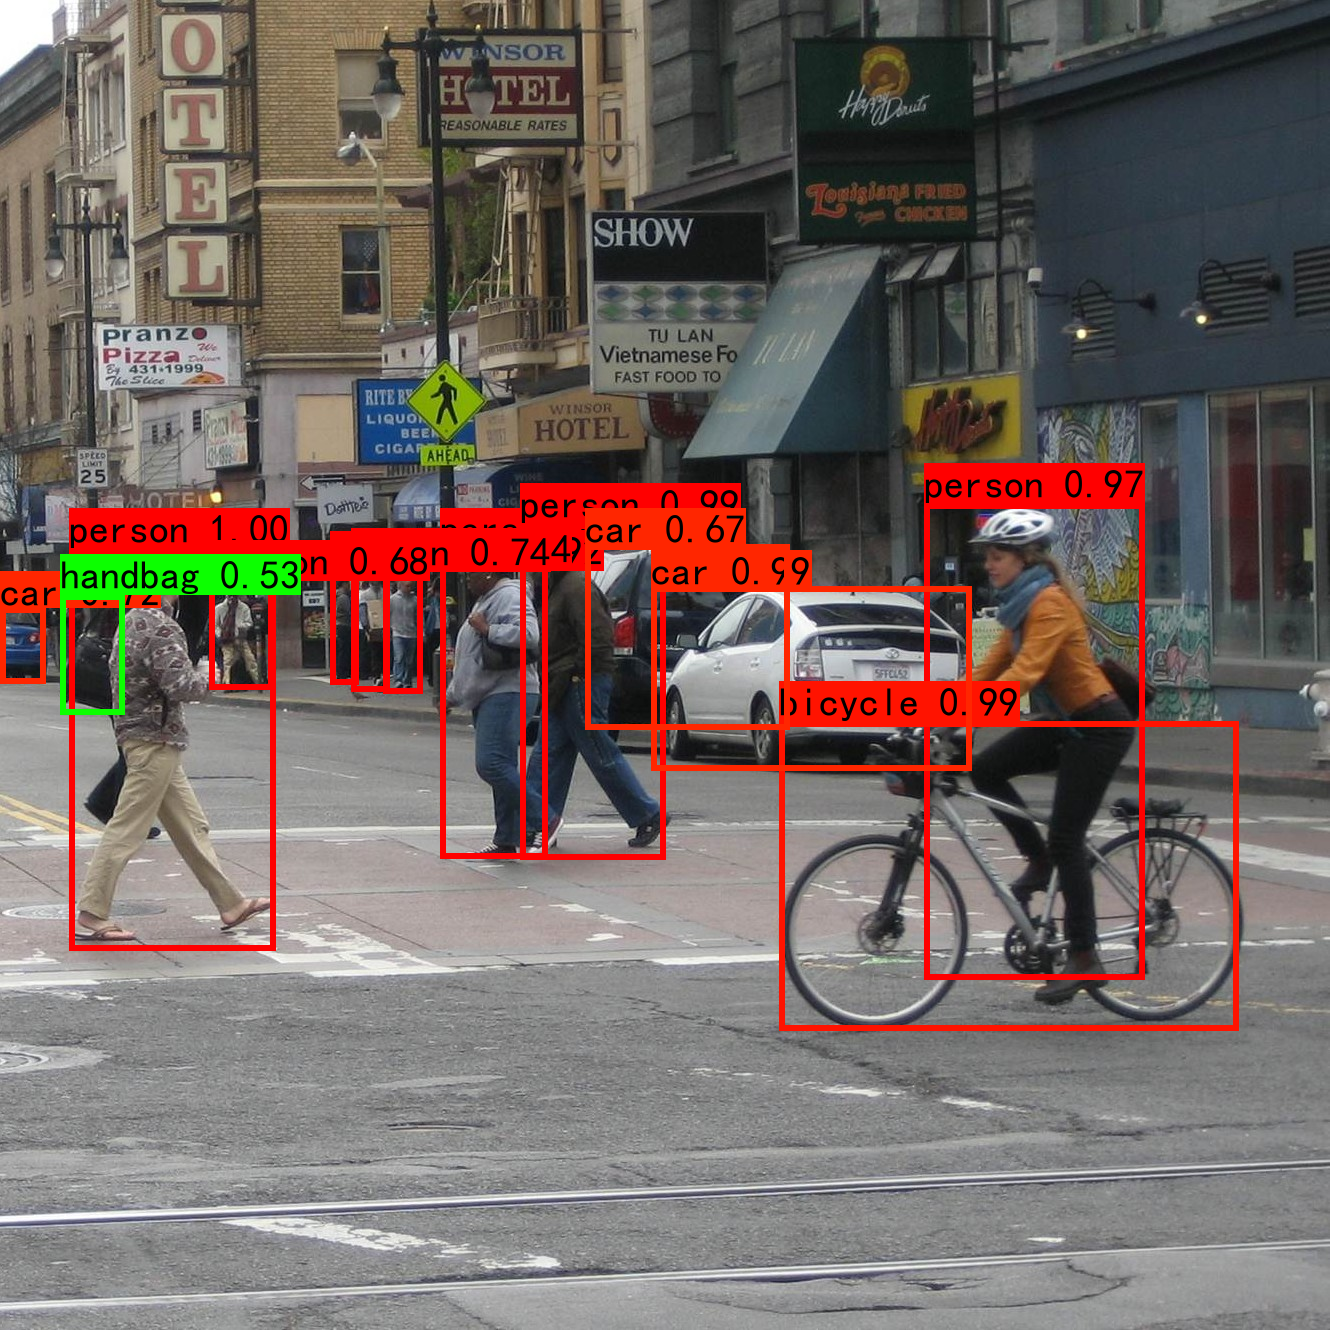

In [60]:
r_image

#### 各種預測模式範例

In [ ]:
yolo = YOLO()
#----------------------------------------------------------------------------------------------------------#
#   mode用于指定测试的模式：
#   'predict'表示单张图片预测，如果想对预测过程进行修改，如保存图片，截取对象等，可以先看下方详细的注释
#   'video'表示视频检测，可调用摄像头或者视频进行检测，详情查看下方注释。
#   'fps'表示测试fps，使用的图片是img里面的street.jpg，详情查看下方注释。
#   'dir_predict'表示遍历文件夹进行检测并保存。默认遍历img文件夹，保存img_out文件夹，详情查看下方注释。
#----------------------------------------------------------------------------------------------------------#
mode = "predict"
#-------------------------------------------------------------------------#
#   crop指定了是否在单张图片预测后对目标进行截取
#   crop仅在mode='predict'时有效
#-------------------------------------------------------------------------#
crop            = False
#----------------------------------------------------------------------------------------------------------#
#   video_path用于指定视频的路径，当video_path=0时表示检测摄像头
#   想要检测视频，则设置如video_path = "xxx.mp4"即可，代表读取出根目录下的xxx.mp4文件。
#   video_save_path表示视频保存的路径，当video_save_path=""时表示不保存
#   想要保存视频，则设置如video_save_path = "yyy.mp4"即可，代表保存为根目录下的yyy.mp4文件。
#   video_fps用于保存的视频的fps
#   video_path、video_save_path和video_fps仅在mode='video'时有效
#   保存视频时需要ctrl+c退出或者运行到最后一帧才会完成完整的保存步骤。
#----------------------------------------------------------------------------------------------------------#
video_path      = 0
video_save_path = ""
video_fps       = 25.0
#-------------------------------------------------------------------------#
#   test_interval用于指定测量fps的时候，图片检测的次数
#   理论上test_interval越大，fps越准确。
#-------------------------------------------------------------------------#
test_interval   = 100
#-------------------------------------------------------------------------#
#   dir_origin_path指定了用于检测的图片的文件夹路径
#   dir_save_path指定了检测完图片的保存路径
#   dir_origin_path和dir_save_path仅在mode='dir_predict'时有效
#-------------------------------------------------------------------------#
dir_origin_path = "img/"
dir_save_path   = "img_out/"

if mode == "predict":
    '''
    1、如果想要进行检测完的图片的保存，利用r_image.save("img.jpg")即可保存，直接在predict.py里进行修改即可。 
    2、如果想要获得预测框的坐标，可以进入yolo.detect_image函数，在绘图部分读取top，left，bottom，right这四个值。
    3、如果想要利用预测框截取下目标，可以进入yolo.detect_image函数，在绘图部分利用获取到的top，left，bottom，right这四个值
    在原图上利用矩阵的方式进行截取。
    4、如果想要在预测图上写额外的字，比如检测到的特定目标的数量，可以进入yolo.detect_image函数，在绘图部分对predicted_class进行判断，
    比如判断if predicted_class == 'car': 即可判断当前目标是否为车，然后记录数量即可。利用draw.text即可写字。
    '''
    while True:
        img = input('Input image filename:')
        try:
            image = Image.open(img)
        except:
            print('Open Error! Try again!')
            continue
        else:
            r_image = yolo.detect_image(image, crop = crop)
            r_image.show()

elif mode == "video":
    capture = cv2.VideoCapture(video_path)
    if video_save_path!="":
        fourcc  = cv2.VideoWriter_fourcc(*'XVID')
        size    = (int(capture.get(cv2.CAP_PROP_FRAME_WIDTH)), int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT)))
        out     = cv2.VideoWriter(video_save_path, fourcc, video_fps, size)

    ref, frame = capture.read()
    if not ref:
        raise ValueError("未能正确读取摄像头（视频），请注意是否正确安装摄像头（是否正确填写视频路径）。")

    fps = 0.0
    while(True):
        t1 = time.time()
        # 读取某一帧
        ref, frame = capture.read()
        if not ref:
            break
        # 格式转变，BGRtoRGB
        frame = cv2.cvtColor(frame,cv2.COLOR_BGR2RGB)
        # 转变成Image
        frame = Image.fromarray(np.uint8(frame))
        # 进行检测
        frame = np.array(yolo.detect_image(frame))
        # RGBtoBGR满足opencv显示格式
        frame = cv2.cvtColor(frame,cv2.COLOR_RGB2BGR)

        fps  = ( fps + (1./(time.time()-t1)) ) / 2
        print("fps= %.2f"%(fps))
        frame = cv2.putText(frame, "fps= %.2f"%(fps), (0, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

        cv2.imshow("video",frame)
        c= cv2.waitKey(1) & 0xff 
        if video_save_path!="":
            out.write(frame)

        if c==27:
            capture.release()
            break

    print("Video Detection Done!")
    capture.release()
    if video_save_path!="":
        print("Save processed video to the path :" + video_save_path)
        out.release()
    cv2.destroyAllWindows()

elif mode == "fps":
    img = Image.open('img/street.jpg')
    tact_time = yolo.get_FPS(img, test_interval)
    print(str(tact_time) + ' seconds, ' + str(1/tact_time) + 'FPS, @batch_size 1')

elif mode == "dir_predict":
    import os
    from tqdm import tqdm

    img_names = os.listdir(dir_origin_path)
    for img_name in tqdm(img_names):
        if img_name.lower().endswith(('.bmp', '.dib', '.png', '.jpg', '.jpeg', '.pbm', '.pgm', '.ppm', '.tif', '.tiff')):
            image_path  = os.path.join(dir_origin_path, img_name)
            image       = Image.open(image_path)
            r_image     = yolo.detect_image(image)
            if not os.path.exists(dir_save_path):
                os.makedirs(dir_save_path)
            r_image.save(os.path.join(dir_save_path, img_name.replace(".jpg", ".png")), quality=95, subsampling=0)

else:
    raise AssertionError("Please specify the correct mode: 'predict', 'video', 'fps' or 'dir_predict'.")